<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC30000 Lab 1 Balancing a Pole on a Cart

## Team Name: JSS
Name of members and contributions:

| *Name*                                            |    *Contribution*                                                     |
| --------------------------------------------------|-----------------------------------------------------------------------|
| Lian Hong Shen Jordan                             |         Writing of code for the main Q learning alogrithm             |
| Lui Shi Ying                                      |         Analysis of algorithm and formatting of note book             |
| Palanca Sebasatian Gonzalo Miguel IV Puyat        |         Abstraction of Q learning algorithm and analysis of algorithm |

## Preparation 
## 1. Install dependencies

In [93]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install tensorflow
!pip install moviepy

The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.


## 2. Importing dependencies and define helper functions

In [94]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## 3. Understanding the CartPole-v1 Environment

In [95]:
#gym.make(env_name): Call constructor of the passed in env_name
env = gym.make("CartPole-v1")

In [96]:
#Get the documentation of the environment 
help(env)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env: gym.core.Env, max_episode_steps: Optional[int] = None)
 |  
 |  This wrapper will issue a `truncated` signal if a maximum number of timesteps is exceeded.
 |  
 |  If a truncation is not defined inside the environment itself, this is the only place that the truncation signal is issued.
 |  Critically, this is different from the `terminated` signal that originates from the underlying environment as part of the MDP.
 |  
 |  Example:
 |     >>> from gym.envs.classic_control import CartPoleEnv
 |     >>> from gym.wrappers import TimeLimit
 |     >>> env = CartPoleEnv()
 |     >>> env = TimeLimit(env, max_episode_steps=1000)
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, max_episode_steps: Optional[int] = Non

### 3.1 Understanding the action space of the CartPole-v1 environment

In [97]:
#Display whether the action space of the environment is continuous and discrete 
#and the number of valid or allowable actions 
print(env.action_space)

Discrete(2)


- Discrete(2) means that there are two valid discrete actions: 0 & 1.
- In the CartPole-v1 environment, 0 corresponds to a left push and 1 corresponds to a right push

### 3.2 Understanding the observation space of the CartPole-v1 environment 

In [98]:
#Finding valid values for the observation of states in the CartPole-v1 environment 
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


- The first array defines the minimum values of the 4 observations 
- The second array defines the maximum values of the 4 observations
- The 4 observations in the CartPole-v1 environment include: 
    1. Cart Position
    2. Cart Velocity 
    3. Pole Angle
    4. Angular Velocity.



## 4. Episodes in Reinforcement Learning 
- Reinforcement Learning requires the agent to take actions, gain rewards from actions taken and learn to opitimize rewards earned
- Therefore, we require the agent to go through events in which it interacts with the environment and develop a better understanding on which actions should be taken from each state
- Hence, to faciliate Reinforcement Learning, episodes are required. 
- For this, we need to:  
    - Ensure that the environment is reset before every episode 
    - Ensure we know when the episode is supposed to end 

### 4a. Reseting environment before every episode

- We call each round of the pole-balancing game an "episode".
- At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. 
- An environment reset is required whenever an episode is terminated or truncated.
- This initialization can be achieved by the code below, which returns the observation of the initial state.

In [99]:
#.reset(): resets environment to initial state
#also returns observation of the randomly chosen initial state  
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([-2.8577695e-02,  4.8255157e-02, -3.2133657e-02,  9.9164259e-05],
      dtype=float32), {})


### 4b. Understanding when each episode ends and rewards gained after each episode

- For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. 
    - For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project).
    
- For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

The **episode ends** if any one of the following occurs:<br>
**Termination**: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display) <br>
**Termination**: Pole Angle is greater than ±12° (±0.20944 rad)<br>
**Truncation**: Episode length is greater than 500.


In [100]:
# step(x): Choose an action (0 or 1)
observation, reward, terminated, truncated, info = env.step(1)

# Observation: Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
print("New observations after choosing action 0:", observation)

# Reward: 1 for every step taken, including the termination step
print("Reward for this step:", reward)

# Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
# Termination: Pole Angle is greater than ±12° (±0.20944 rad)
print("Is this round terminated?", terminated)

# Truncation: Episode length is greater than 500
print("Is this round truncated?", truncated)

New observations after choosing action 0: [-0.02761259  0.24382286 -0.03213167 -0.30254662]
Reward for this step: 1.0
Is this round terminated? False
Is this round truncated? False


## 5. Playing the game using Naive Strategy

Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [101]:
observation = env.reset()
cumulative_reward = 0
truncated = terminated = False

# Putting trunctated only will result in a 500 episode lenth before it terminates
print("\t\t\t\t\tCart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip")

while not (truncated or terminated):
    observation, reward, terminated,truncated, info = env.step(0)
    print(f"New observations after choosing action {int(cumulative_reward)}:", observation)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
print("Is this round terminated?", terminated)
print("Is this round truncated?", truncated)

					Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
New observations after choosing action 0: [-0.0322854  -0.17526694 -0.02900626  0.27613652]
New observations after choosing action 1: [-0.03579074 -0.36996332 -0.02348353  0.55953157]
New observations after choosing action 2: [-0.04319001 -0.5647479  -0.0122929   0.8447244 ]
New observations after choosing action 3: [-0.05448496 -0.7597      0.00460159  1.1335164 ]
New observations after choosing action 4: [-0.06967896 -0.95488185  0.02727192  1.427639  ]
New observations after choosing action 5: [-0.0887766 -1.1503298  0.0558247  1.7287189]
New observations after choosing action 6: [-0.1117832  -1.3460435   0.09039907  2.038236  ]
New observations after choosing action 7: [-0.13870406 -1.5419722   0.13116379  2.35747   ]
New observations after choosing action 8: [-0.1695435 -1.7379992  0.1783132  2.6874366]
New observations after choosing action 9: [-0.20430349 -1.9339237   0.23206192  3.0288103 ]
Cumulative reward fo

# <font color='lightgreen'> Our implementation </font>

- After preparing all the required depedencies and helper functions and upon learning about our environment, we are ready to develop a Reinforcement Learning agent. 

- Here, we selected the "Q Learning" model-free, off-policy reinforcement learning that will find the best course of action, given the current state of the agent. 


# Developing the RL agent

### Steps to construct our Q-Learning Algorithm: 

1. Create and define our Q table
    - A funciton to create a Q-Table
    - The function should return a tuple of the with bins of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.<br>
    

2. Conduct binning to create discrete intervals to faciliate discretisation of our continuous observation space. <br>

3. Convert the continuous state space using the user-defined function Discrete(state,bins) 

4. Define our Q-Learning Algorithm 

5. Train and define the RL agent

In [130]:
#PREPARATION
#Make the cartpole environment 
env = gym.make('CartPole-v1')

#Set our bin size to be 30 so that are are reasonably size intervals for discretisation
bin_size = 30

### Step 1: Create a Q-table 

- Our Q-table has rows containing all potential combinations of dicretised states and columns containing all possible actions. 

- Including all possible combinations of states and actions gives rise to a table shape of [bin_size] * state_space + [action_space] 
<br>--> which is [30 30 30 30 2] in our case as we have chosen bin size to be 30.

- Subsequently, this Q-table will be referenced to obtain Q-values that are indicators for the agent to determine the best action to be taken when it is in a particular state. 

- The agent would scan the Q-table for the highest Q-value or Q(s,a), and follow that action.

- The following is a simplified pictorial visualisation of our Q-table:  
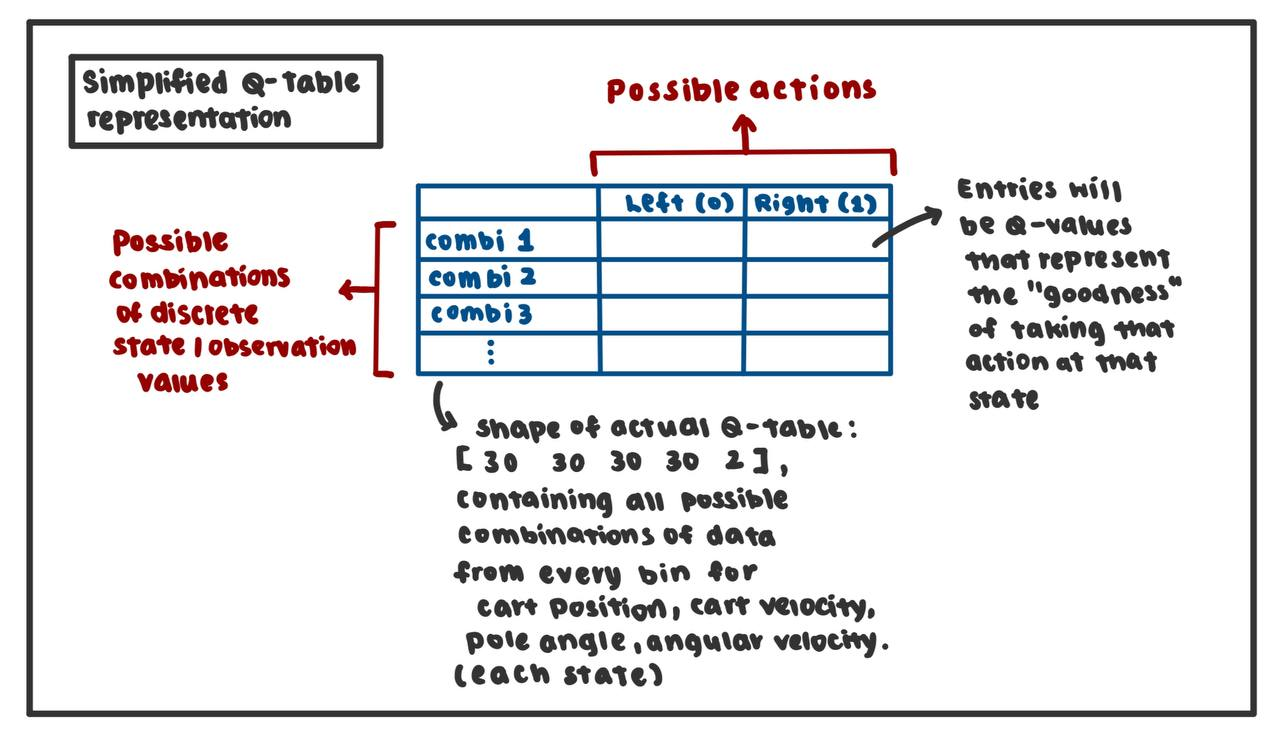

If you are unable to view the image, click on this link: https://drive.google.com/file/d/1sEFHfRqSKNzjuImNIIxuggws1mHqh8lz/view?usp=sharing

In [131]:
#FUNCTION TO CREATE AND INITIALIZE Q-TABLE
def CreateQtable(state_space,action_space,bin_size):
    #Create our Q-table of size [30 30 30 30 2]
    #Initialize the entire table to 0 for to allow the agent to begin with randomness
    #After training, the agent will then update these Q-table entries to updated Q-values 
    #np.zeros(): returns an array of zeros with the passed in shape
    q_table = np.zeros(shape=([bin_size] * state_space + [action_space]))
    return q_table

#CREATE THE Q-TABLE 
created_qtable = CreateQtable(len(env.observation_space.low),env.action_space.n, bin_size) 

### Step 2: Binning 

- To ensure efficiency and functionality, the size of our Q-table is bounded time and space restrictions. <br> 

- This signifies that we are unable to cater to CartPole-v1's continuous observation space. Therefore, we have to create bins or pre-defined intervals in which every continuous state value can fall under. <br> 

- Such bins would help to facilitate the discretization of continous states into discrete states and enable us to create a reasonably-sized Q-table. <br> 

The following diagram describes how the binning process works: 
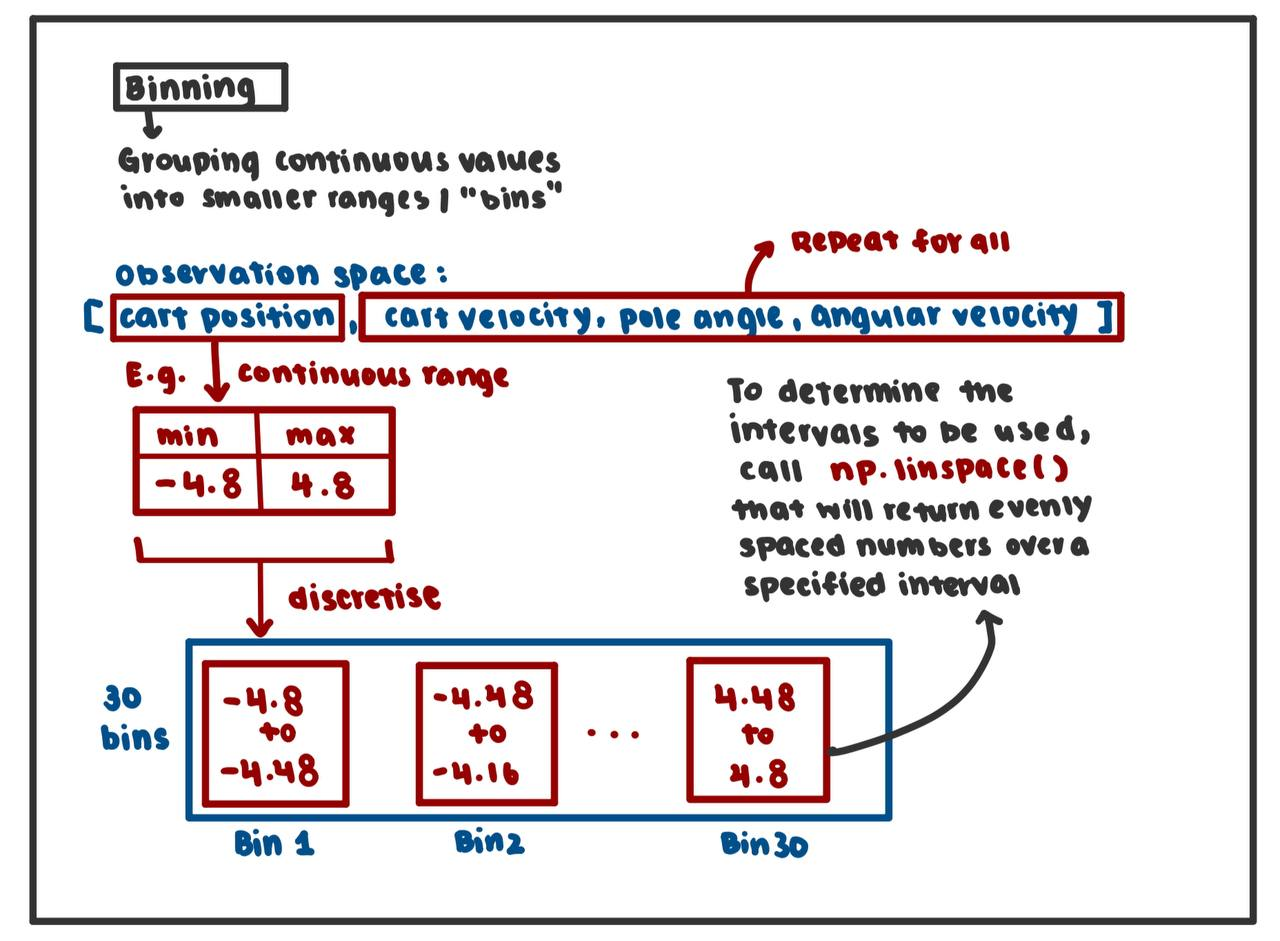

If you are unable to view the image, click on this link: https://drive.google.com/file/d/1C8HYvZc0jKHtKTguyVrQc6y2s4nBxaeB/view?usp=sharing

In [132]:
#FUNCTION TO CREATE BINS FOR EACH STATE (cart position, velocity and pole angle, angular velocity)
def CreateBins(bin_size): 
    #np.linspace(): returns evenly spaced numbers over a specified interval
    #syntax: np.linspace(start_val, end_val, num_of_samples_generated) 
    #We chose the start_val and end_val here to be the upper and lower limits for each state 
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    return bins 

#CREATE BINS 
created_bins = CreateBins(bin_size) 

### Step 3: Discretizing of continuous observation space

- To convert our continuous observation space into a discrete observation space, we made use of the np.digitize() function. <br> 

- The function helps us to categorise the states values into their respective bins according to the range in which their value falls into <br> 

The following diagram explains how np.digitize() works: 
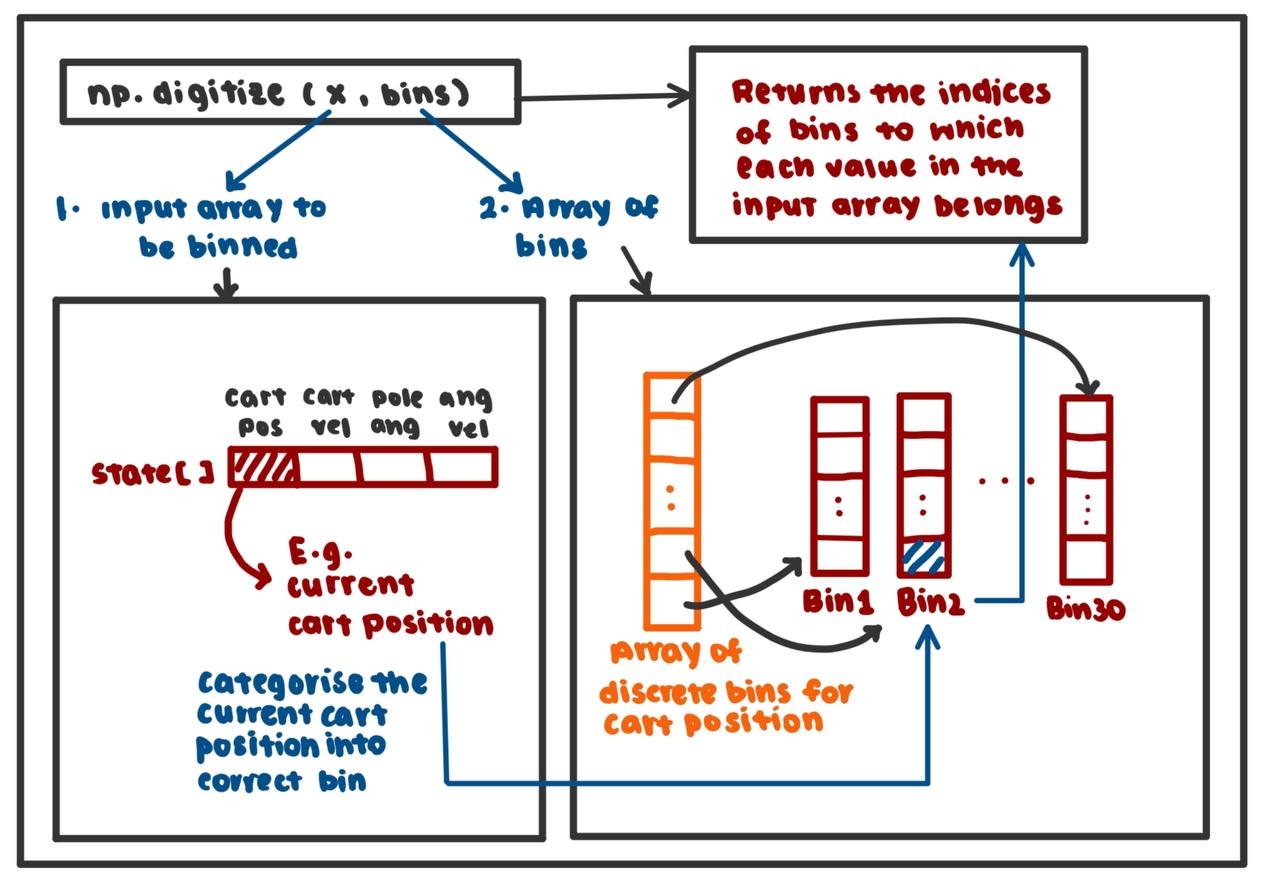

If you are unable to view the image, click on this link: https://drive.google.com/file/d/103SX3hlmuZUlrBDVKRVyJemzqIDstJA-/view?usp=sharing

In [133]:
# Discretize the state
def Discrete(state, bins):

    bin_indices = []

    #np.digitize(): return the indices of the bins to which each value in input array belongs.
    #syntax: np.digitize(x, bins) -- where x = input array to be binned, bins = array of bins
    for i in range(len(state)): 
        bin_indices.append(np.digitize(state[i],bins[i]) - 1)

    return tuple(bin_indices)

### Step 4: Definining the Q-Learning Algorithm

- Firstly, the algorithm will begin by discretising the current state to facilitate searching up the Q-table thereafter 
- If the episode is neither terminated nor truncated, the agent proceeds to choose between exploring or exploiting the current Q-table under the Epsilon-Greedy policy 

The following explains the use of epsilon in our Q-Learning Algorithm: 
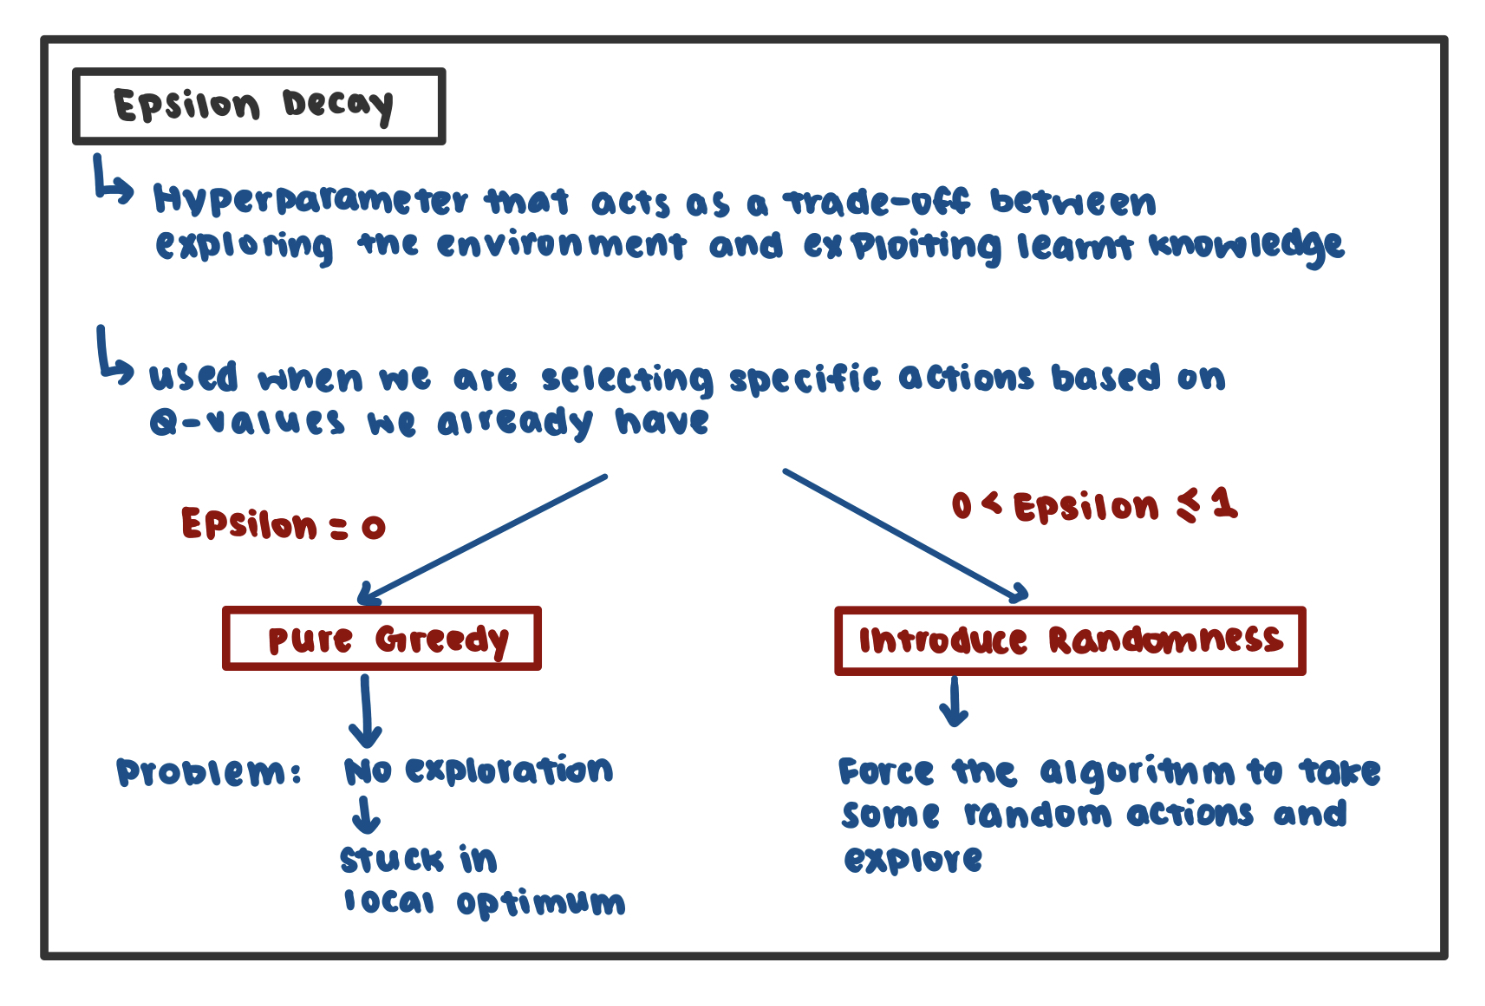

- The agent proceed to take the chosen action, discretize the next state and calculate the rewards earned


Then, we have to update the Q-table using the Temporal Difference formula : 
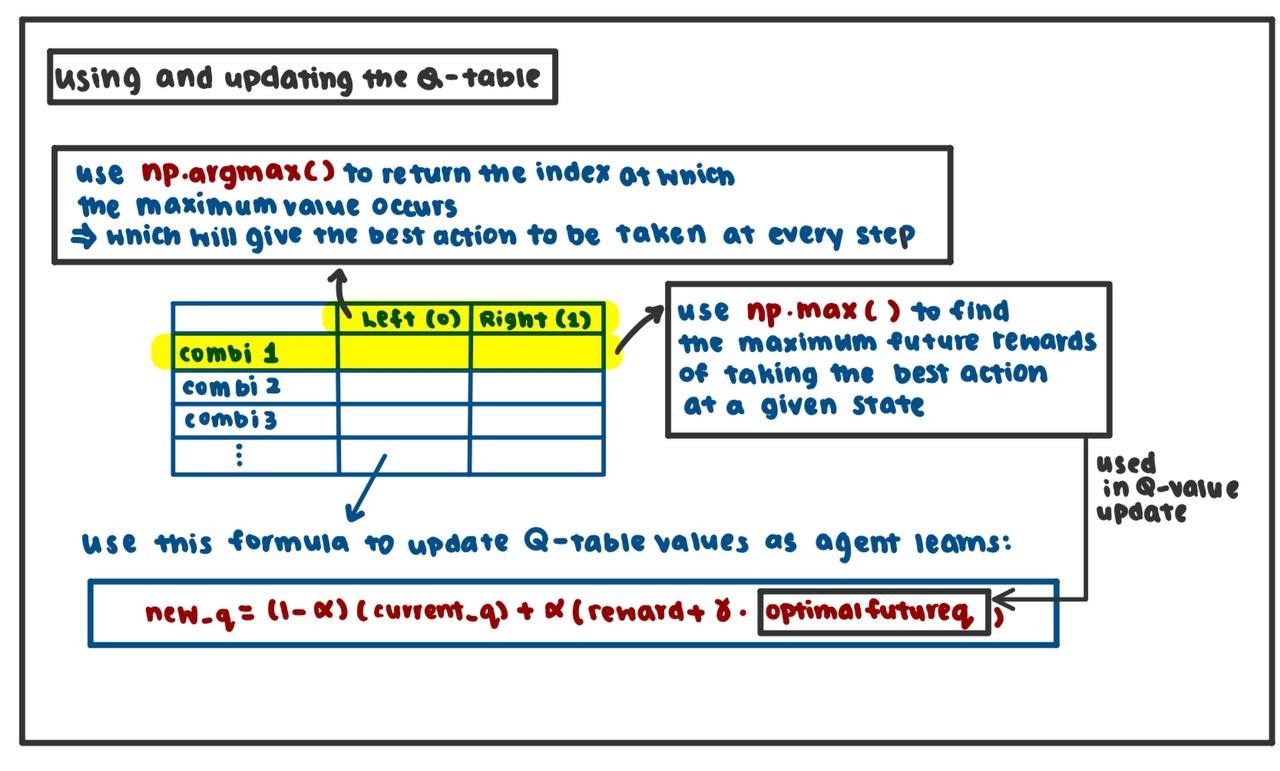

If you are unable to view the images, click on these links: 
- https://drive.google.com/file/d/1cmJ2WP7wmr7f4OrAnO-_nYIytqpGwVml/view?usp=sharing
- https://drive.google.com/file/d/1kGrNWPjbeFVheQ5ca4f8GwrOPBUDs7ae/view?usp=share_link

### 4.1 Executing an individual episode under a Q-Learning Algorithm 

To actually generate the episodes, we use the Q_learning_algo() function, which uses different methods for when we're training the model, or testing it, this is done through the training parameter, where modification of the q_table is locked by the training parameter.

We evaluate only the next state, and we update the Q Table based on the reward achieved from generating the next state. 

In [134]:
# Executes one episode based on the current policy from the Q Table
 
def Q_learning_algo(qtable, bins, learningrate, discount, epsilon, train):
        # Start of new episode, get the initial observation for the new round 
        current_state = Discrete(env.reset()[0],bins) 
        
        # totalrewards: records total rewards earned in this episode 
        # Note: In CartPole-v1, a reward of +1 is given for every step taken
        # takensteps: records the total number of steps taken in this episode 
        episode_totalrewards = episode_takensteps = 0
        terminated = truncated =  False
        
        # Continue to take steps unless terminated or truncated condition met
        while not (terminated or truncated):
            # Increment the step count if episode has not ended 
            episode_takensteps += 1 
        
            # Epsilon-Greedy policy 
            if np.random.uniform(0,1) < epsilon and train == True: 
                # Randomly explore the environment 
                action = env.action_space.sample()
            else: 
                # Exploit the currently constructed qtable 
                action = np.argmax(qtable[current_state])
            
            # Take the action selected under Epsilon-Greedy 
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = Discrete(observation,bins)

            # Update total rewards with newly earned reward from action taken from state
            episode_totalrewards += reward

            # Update Q-Table if in training mode
            if (not (terminated or truncated)) and train == True:
                # Find the maximum Q-value for the next state
                max_next_q = np.max(qtable[next_state])
                # Get the current Q-value for the current state
                current_q = qtable[current_state+(action,)]
                # Calculate the new Q-value via Temporal Difference Forumla 
                updated_q = (1-learningrate)*current_q + learningrate*(reward + discount*max_next_q)
                # Assign new Q-value to the Q-table
                qtable[current_state+(action,)] = updated_q

            # Update the current state
            current_state = next_state
        
        # This algorithm can be used when training the agent by executing episodes (if)
        # or can be used simply to executing episodes (else)
        if train == True:
            return qtable, episode_totalrewards, episode_takensteps
        else:
            return episode_totalrewards, episode_takensteps

### Step 5: Training the Reinforcement Learning (RL) Agent 

- As the RL agent needs to learn from experience, we will train the agent by running the algorithm for 15000 episodes.
- We create a Q_learning function to run the algorithm for 15000 times and print out the result of when the problem is solved when the cumulative score for an episode exceeds 195.
- Due to the presence of an epsilon, the RL Agent will continuously explore and exploit such that the Q-table gradually contains values that are able to accurately "point out" optimal actions for the agent to take at every state 

In [135]:
# Function that faciliates training of the agent for the specified number of episodes 
def Training(qtable, bins, episodes_to_train, learningrate, discount, epsilon):
    # satisfactory: will return True if the rewards attained and steps taken are satisfactory
    satisfactory = False
    
    # allow the RL agent to interact with the environment under the Q_learning_algo for 
    # the pre-determined number of training episodes 
    for episode_num in range(episodes_to_train):
        
        # record the rewards and steps taken in every episode 
        qtable, episode_reward, episode_steps = Q_learning_algo(qtable, bins, learningrate, discount, epsilon, True)
        
        # for an episode to be considered satisfactory, its reward should be above 195 
        if episode_reward > 195 and satisfactory == False: 
            satisfactory = True
            # record an episode in which the RL agent succeeds in attaining satisfactory reward
            print("Acceptable outcome attained in episode: ", episode_num)
            print("Steps Taken, Rewards Earned:", episode_steps, episode_reward)
            print("Terminated?: ", terminated)
            print("Truncated?: ", truncated)
    print("Training has completed.")
env.close()

In [136]:
# Here, we train our RL agent for 15000 episodes 
Training(created_qtable, created_bins, episodes_to_train = 15*10**3, learningrate = 0.15, discount = 0.995, epsilon= 0.2)

Acceptable outcome attained in episode:  722
Steps Taken, Rewards Earned: 204 204.0
Terminated?:  True
Truncated?:  False
Training has completed.


### Upon training and defining our RL agent, we are ready to observe what actions the agent will choose to take from each state and determine its effectiveness. 

## Task 1: Show the observation and chosen action

Here we define a function that takes in the trained Q table, a given state space and the number of bins to return the optimal action using np.argmax to give the recommended action to take at a given discretized state.

In [137]:
def q_policy_agent(observation, qtable, bins):
    return np.argmax(qtable[Discrete(observation,bins)])

In [138]:
observation = env.reset()
action = q_policy_agent(observation[0], created_qtable, created_bins)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([ 0.01344733,  0.02705221,  0.00034306, -0.01117964], dtype=float32), {})
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

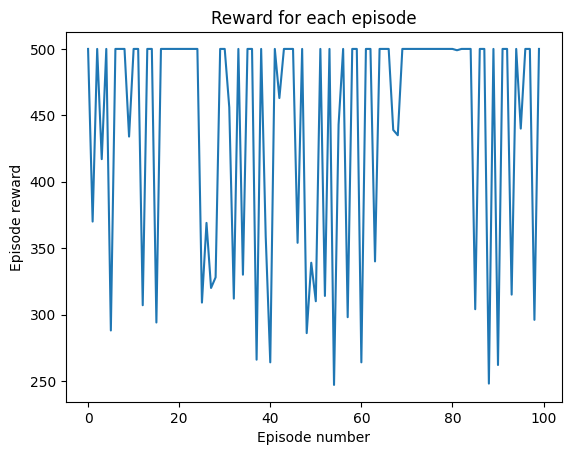

In [139]:
# Test the agent
episode_outcome = {'episode number':[],'rewards earned':[]}

# Run the agent for 100 episodes 
for episode_num in range(100):
    # Run through the trained Q_learning_algo 100 times to execute 100 individual episodes 
    # Here we set learning rate, discount and epsilon to 0 and 
    # train to False as we are merely making use of the algorithm to execute episodes 
    episode_rewards, episode_steps = Q_learning_algo(created_qtable, created_bins, learningrate=0, discount=0, epsilon=0, train=False)
    
    # Record the rewards for every episode and its corresponding episode number  
    episode_outcome['rewards earned'].append(episode_rewards)
    episode_outcome['episode number'].append(episode_num)

# Plot graph for rewards in each of the 100 episodes 
plt.plot(episode_outcome['rewards earned'])
plt.title('Reward for each episode')
plt.ylabel('Episode reward')
plt.xlabel('Episode number')
plt.show()


Print the average reward over the 100 episodes.

In [140]:
# Find average reward for the agent 
print("Average reward :", np.array(episode_outcome['rewards earned']).mean())

# For agent to be good enough, average reward per episode should exceed 195
print("Is my agent good enough?", np.array(episode_outcome['rewards earned']).mean() > 195)

Average reward : 443.19
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [141]:
env = RecordVideo(gym.make("CartPole-v1",render_mode = "human"),"./video")

# Start of new episode, reset the environment first 
observation = env.reset()
# Reset number of steps taken to 0 
takensteps = 0
# Print the random initial observation 
observation = observation[0]
print(observation)

# Render one episode by our RL agent 
while True:
  takensteps +=1 
  env.render()
  action = q_policy_agent(observation, created_qtable, created_bins)
  observation, reward, terminated, truncated, info = env.step(action) 
  if (terminated or truncated):
    print("Ended in step:",takensteps)
    break
env.close()
show_video()

[ 0.00027912  0.01233006  0.0174078  -0.0318596 ]
Ended in step: 500
Could not find video
